In [1]:
import pandas as pd

import neutcurve
from neutcurve.colorschemes import CBMARKERS, CBPALETTE

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

import warnings
warnings.filterwarnings("ignore")

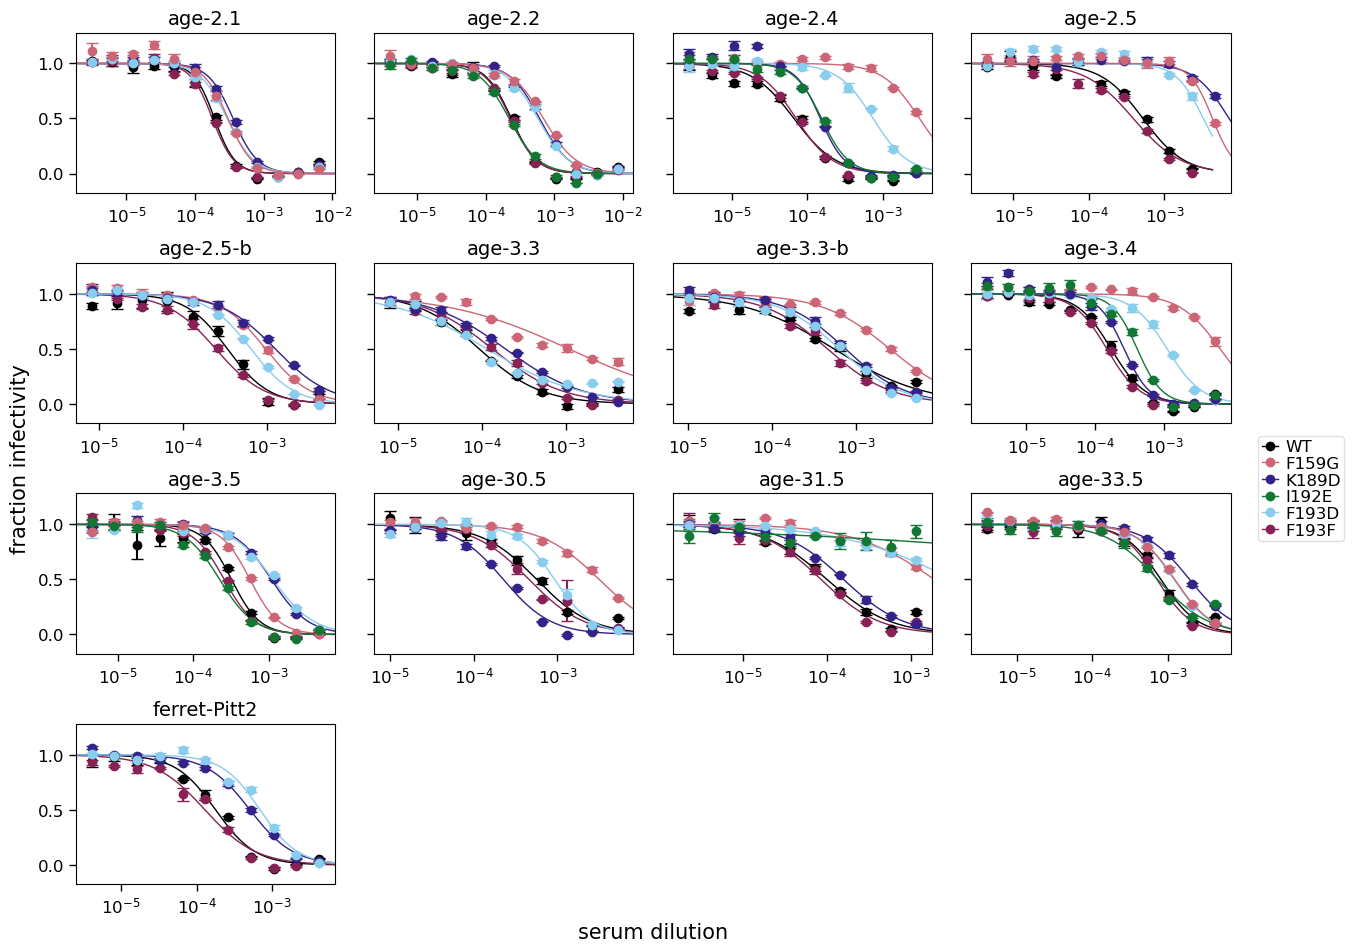

In [13]:
data = pd.read_csv('neutdata.csv')
data=data[data['name'] != 'age-64-Hutch']

data['virus'] = data['virus'].str.replace('_2', '')

data = data[data['virus'].isin(['wt', 'F193F', 'F159G', 'K189D', 'I192E', 'F193D'])]
data['virus'] = data['virus'].replace({'wt': 'WT'})

virus_colors = {
    'WT': ['black', 'o'],
    'F159G': ['#CC6677', 'o'],
    'K189D': ['#332288', 'o'],
    'I192E': ['#117733', 'o'],
    'F193D': ['#88CCEE', 'o'],
    'F193F': ['#882255', 'o'],
}

# fit with neutcurve package
fits = neutcurve.CurveFits(data,
                           serum_col='name'
                          )

colors = ['black'] + list(CBPALETTE)

fig, axes = fits.plotSera(xlabel='serum dilution',
                          max_viruses_per_subplot=7,
                          virus_to_color_marker=virus_colors,
                          ncol=4,
                          sharex=False
                         )

bbox = matplotlib.transforms.Bbox([[0, 0], [15, 10.5]])
plt.savefig('full_neut_curves_perth09.pdf', bbox_inches=bbox)

In [12]:
def get_fold_changes(fits, ic):
    ic_df = fits.fitParams(ics=[ic])
    
    # drop 'wt2' entries
    ic_df = ic_df[ic_df['virus'] != 'wt2']

    # Initialize an empty DataFrame to store the results
    fold_changes = pd.DataFrame()

    # Iterate through unique serum names
    for serum_name in ic_df['serum'].unique():
        # Filter data for the current serum
        serum_data = ic_df[ic_df['serum'] == serum_name]

        # Find the 'WT' ICX value for the current serum
        wt_ic = serum_data[serum_data['virus'] == 'wt'][f'ic{ic}'].values[0]

        # Filter out the 'WT' rows for the current serum
        variant_data = serum_data[serum_data['virus'] != 'wt'].copy()

        # Calculate log2 fold changes for the current serum
        variant_data[f'log2_fold_change_ic{ic}'] = np.log2(variant_data[f'ic{ic}'] / wt_ic)

        # Append the results to the fold_changes DataFrame
        fold_changes = pd.concat([fold_changes, variant_data[['serum', 'virus', f'log2_fold_change_ic{ic}', ]]])

    # Reset the index of the final DataFrame
    fold_changes = fold_changes.reset_index(drop=True)

    # Rename the 'virus' column to 'variant'
    fold_changes = fold_changes.rename(columns={'virus': 'variant'})
    
    return fold_changes

In [13]:
ics = [50, 80, 90]

for ic in ics:
    fold_changes = get_fold_changes(fits, ic)
    
    fold_changes.to_csv(f'ic{ic}_fold_changes.csv', index=False)